# Necessary Imports
* We use tensorflow for keras and vgg19
* We use pandas for manipulating data
* We use os for filepaths
* Tqdm is not necessary but helpful for visualization
* Seaborn is nice for visualization

In [40]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os
from pathlib import Path
import re 
import tensorflow as tf
from tensorflow import keras 
from keras import layers 
from keras.optimizers import Adam
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.regularizers import l2
from keras.applications.vgg19 import preprocess_input
from os import listdir
from os.path import isfile, join
import os.path as osp
from PIL import Image

<h1>1) Run the Following Cell</h1>

* This imports needed Keras libraries
* Then, it gets the trained VGG19 imagenet model with the prediction layer turned off, because it is not needed for the images in this program
* Then, it prints out the names of all the layers in that model

In [41]:
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.utils import load_img
from keras.models import Model

base_model = VGG19(weights='imagenet',include_top=False, input_shape=(224,224,3))
xs,ys=224,224

for layer in base_model.layers:
    print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


<h2>Preparing VGG19 model</h2>

In this program we will be using the block5_conv4 layer as the output layer because it will extract the greatest amount of detail from the images.

In [42]:
layer = 'block5_conv4'

model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer).output)

## Load the CSV File
This CSV file contains the pokemon name, type 1, and type 2 (if applicable). However, in this model we revmoved the second typing as it would be too hard to predict both with such a small dataset

In [43]:
# Load the CSV file containing the Pokemon names and typings
directory = 'images/pokemonimages'
path = Path(directory)

pokemon_images = list(path.glob('*.png'))
pokemon_name = [os.path.split(x)[1] for x in list(path.glob('*.png'))] 
image_df = pd.concat([pd.Series(pokemon_name, name='Name'), pd.Series(pokemon_images, name='Filepath').astype(str)], axis=1)
image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x))
image_df.head()

name_df = pd.read_csv('pokemon.csv')

joined_df = image_df.merge(name_df, on='Name')

joined_df = joined_df.drop(['Name', 'Type2'], axis=1) 
joined_df.head()

,Filepath,Type1
0,images/pokemonimages/parasect.png,Bug
1,images/pokemonimages/lumineon.png,Water
2,images/pokemonimages/raikou.png,Electric
3,images/pokemonimages/dedenne.png,Electric
4,images/pokemonimages/pyroar.png,Fire


# Colors!

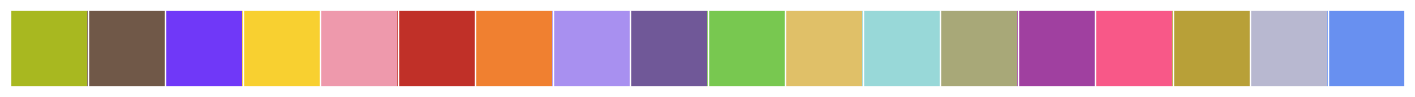

In [44]:
custom_colors = {
    'Bug': '#a8b820',
    'Dark': '#705848',
    'Dragon': '#7038f8',
    'Electric': '#f8d030',
    'Fairy': '#ee99ac',
    'Fighting': '#c03028',
    'Fire': '#f08030',
    'Flying': '#a890f0', 
    'Ghost': '#705898',
    'Grass': '#78c850',
    'Ground': '#e0c068',
    'Ice': '#98d8d8',
    'Normal': '#a8a878',
    'Poison': '#a040a0',
    'Psychic': '#f85888',
    'Rock': '#b8a038',
    'Steel': '#b8b8d0',
    'Water': '#6890f0'
}

sns.set(font_scale=1.25) 
sns.set_palette(sns.color_palette(custom_colors.values()))
sns.palplot(sns.color_palette(custom_colors.values()),size=1)

<h2>View Number of Pokemon in Each Type</h2>

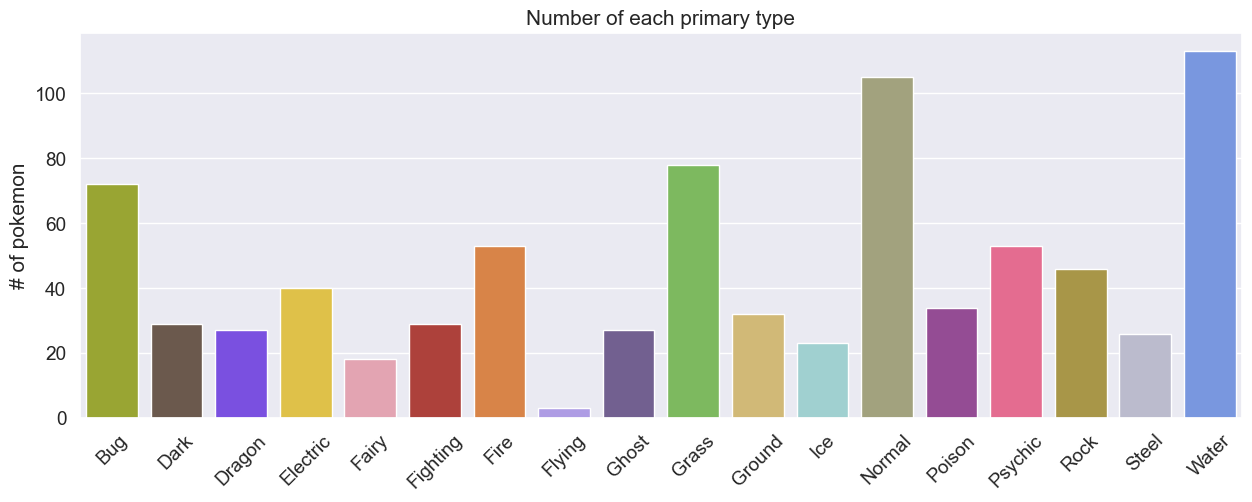

In [45]:
# This will find the number of pokemon that have a specific first type in the dataset
type1 = list(custom_colors.keys())
type1_nums = []
for type in type1:
  type1_nums.append(sum(joined_df['Type1']==type))

type1_data = pd.DataFrame(data=type1_nums, index=type1, columns=['# of pokemon'])


# plot number of each type of pokemon
plt.figure(figsize=(15,5))
plt.title('Number of each primary type')
ax = sns.barplot(x=type1_data.index, y='# of pokemon', data=type1_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
plt.show()


# Print the First Pokemon of each Typing

This gives us an overview of different characteristics of each typing, that may help us make a decision on which typings to choose

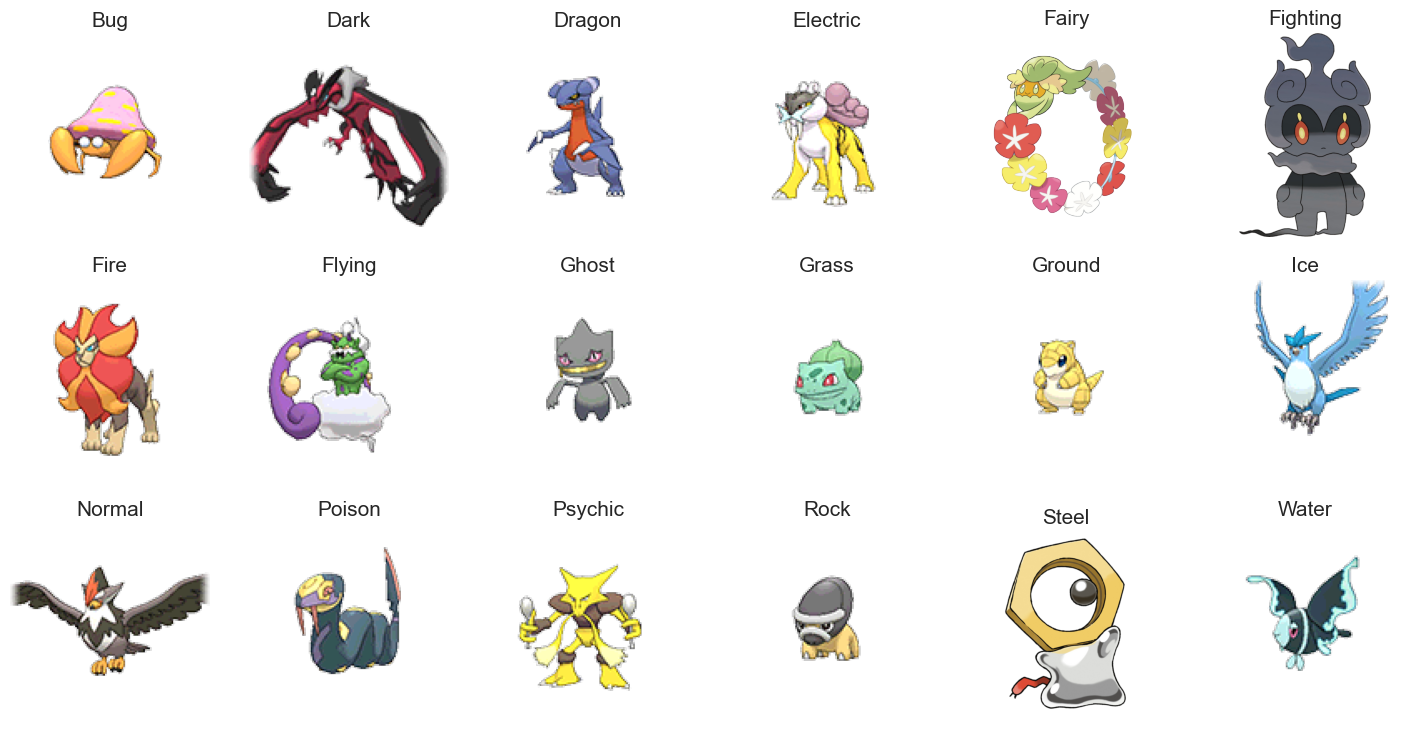

In [46]:
#find the first occurence of a specific pokemon type 
first_type_indeces = []
for type in type1: 
    first_type_indeces.append(joined_df[joined_df['Type1']==type].index[0])

images = []
for index in first_type_indeces:
    images.append(mpimg.imread(joined_df.iat[index, 0]))
    
# display the images 
f, axarr = plt.subplots(3,6, figsize=(18,9))
count = 0 
for r in range(3):
    for c in range (6): 
        axarr[r,c].imshow(images[count])
        axarr[r,c].set_title(type1[count])
        axarr[r,c].set_axis_off()
        count+=1
plt.show()



## Display Water Type Pokemon

for this investigation we will be looking at grass and water as they have identifiable characteristics and larger amounts of data

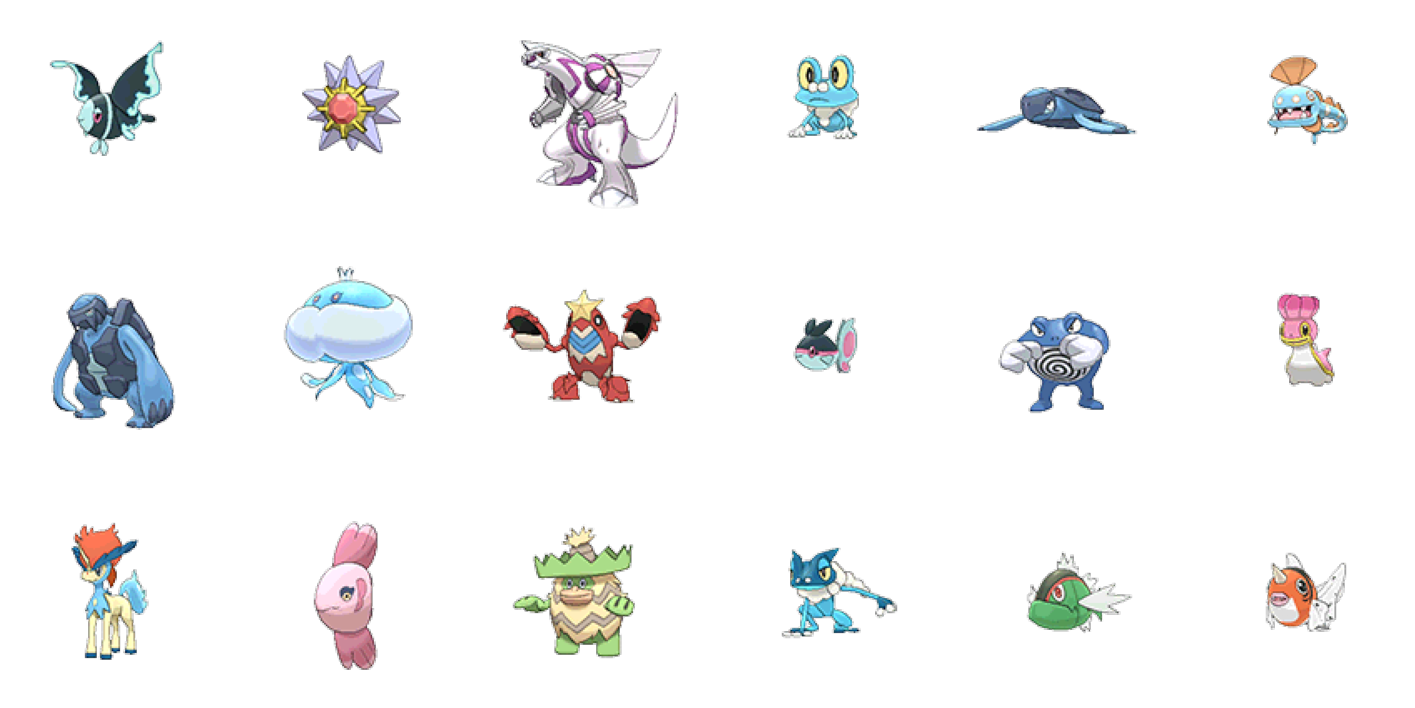

In [47]:
# determine indices
water_indices = []
for i in range(len(joined_df.index)):
  if joined_df.iat[i,1]=='Water':      
    water_indices.append(i)

# obtain images from the filepaths at the determined indices
water_imgs = []
for index in water_indices:
  water_imgs.append(mpimg.imread(joined_df.iat[index, 0]))

# output images
f, axarr = plt.subplots(3,6, figsize=(18,9))  
count = 0
for r in range(3):
  for c in range(6):
    axarr[r,c].imshow(water_imgs[count])
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()

## Display Grass Type Pokémon 

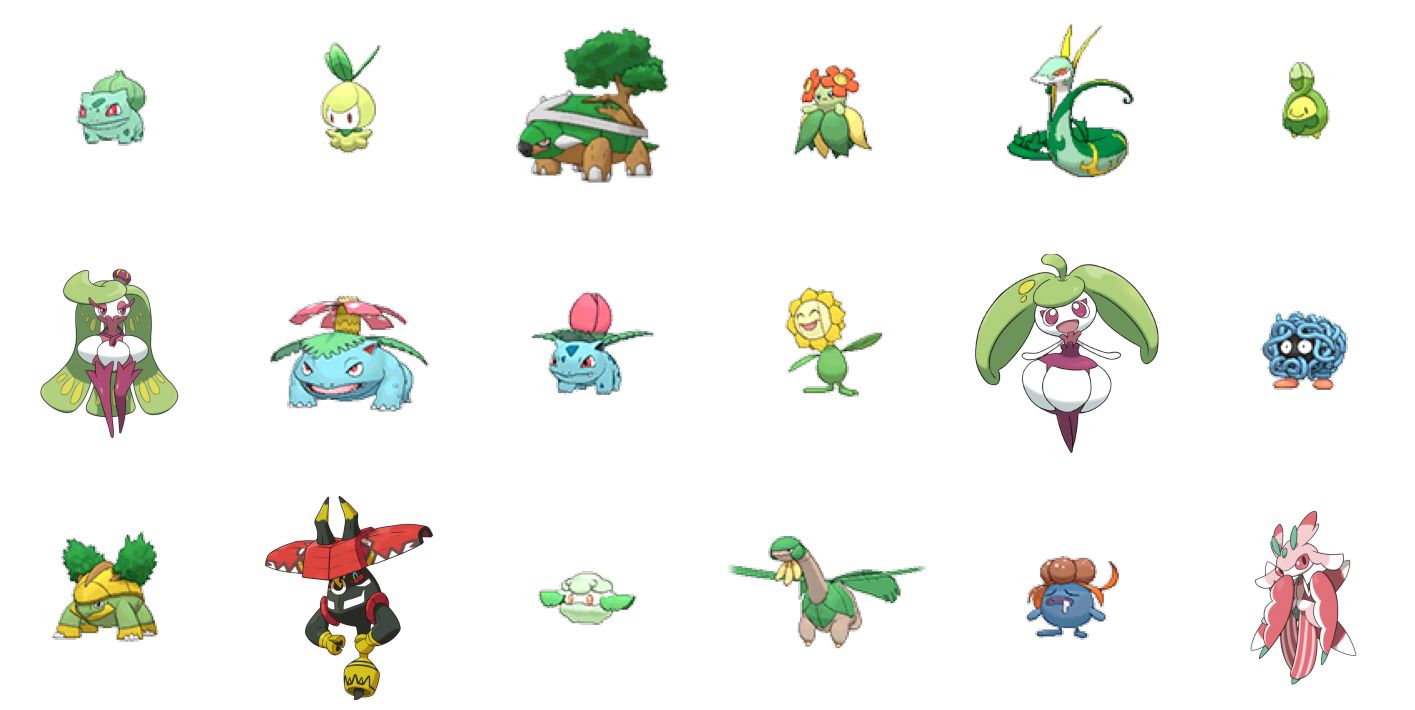

In [48]:
# determine indices
grass_indices = []
for i in range(len(joined_df.index)):
  if joined_df.iat[i,1]=='Grass':      
    grass_indices.append(i)

# obtain images from the filepaths at the determined indices
grass_imgs = []
for index in grass_indices:
  grass_imgs.append(mpimg.imread(joined_df.iat[index, 0]))

# output images
f, axarr = plt.subplots(3,6, figsize=(18,9))  
count = 0
for r in range(3):
  for c in range(6):
    axarr[r,c].imshow(grass_imgs[count])
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()

### Print the Data

In [49]:
joined_df = joined_df.query("Type1 == 'Water' | Type1 == 'Grass'")

# shuffle the data
joined_df = joined_df.sample(frac=1).reset_index(drop=True)

train_gen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_data = train_gen.flow_from_dataframe(
    joined_df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='training',
    shuffle=True
)

val_data = train_gen.flow_from_dataframe(
    joined_df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='validation',
    shuffle = True
)
     


Found 153 validated image filenames belonging to 2 classes.
Found 38 validated image filenames belonging to 2 classes.


# Configure the Model

In [50]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.00013))(x)  # L2 regularization
x = tf.keras.layers.Dropout(0.5999)(x)  # Dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.00013))(x)  # L2 regularization
x = tf.keras.layers.Dropout(0.5999)(x)  # Dropout



num_classes = 2  # Update this value to match the number of classes in your dataset
predictions = Dense(num_classes, activation='softmax')(x)  # Use softmax activation for multi-class classification

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the last few layers of the VGG19 base model
for layer in base_model.layers[-6:]:
    layer.trainable = True

# Recompile the model after updating layer trainability
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000089),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=30)

epochs = 145

# Fit the Model

In [51]:
model.fit(train_data,
          validation_data=val_data,
          batch_size=29,
          epochs=epochs,
          callbacks=[early_stopping])

Epoch 1/145


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
2023-05-01 12:03:06.304921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 1.0715 - accuracy: 0.4902

2023-05-01 12:03:09.556210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 4s 667ms/step - loss: 1.0715 - accuracy: 0.4902 - val_loss: 0.7973 - val_accuracy: 0.3684
Epoch 2/145
5/5 [==============================] - 2s 399ms/step - loss: 0.8413 - accuracy: 0.5098 - val_loss: 0.6383 - val_accuracy: 0.7105
Epoch 3/145
5/5 [==============================] - 2s 377ms/step - loss: 0.9269 - accuracy: 0.4706 - val_loss: 0.6834 - val_accuracy: 0.7895
Epoch 4/145
5/5 [==============================] - 2s 373ms/step - loss: 0.8194 - accuracy: 0.5359 - val_loss: 0.6318 - val_accuracy: 0.7895
Epoch 5/145
5/5 [==============================] - 2s 354ms/step - loss: 0.6871 - accuracy: 0.6144 - val_loss: 0.6130 - val_accuracy: 0.7632
Epoch 6/145
5/5 [==============================] - 2s 360ms/step - loss: 0.6863 - accuracy: 0.6275 - val_loss: 0.7809 - val_accuracy: 0.5263
Epoch 7/145
5/5 [==============================] - 2s 349ms/step - loss: 0.6475 - accuracy: 0.6993 - val_loss: 0.5958 - val_accuracy: 0.7632
Epoch 8/145
5/5 [========

# Show a sample of the predictions

2023-05-01 12:05:12.693749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 343ms/step
True labels:  [0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 1. 1.]
Predicted labels:  [0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1]


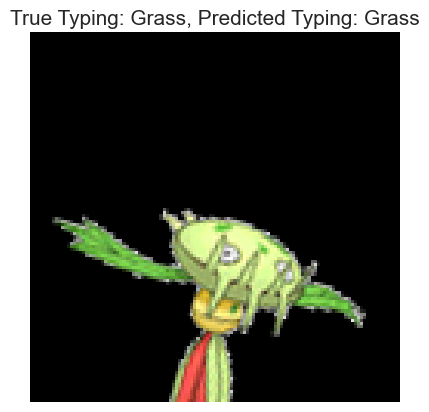

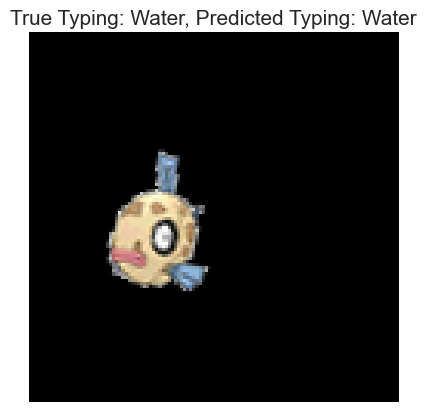

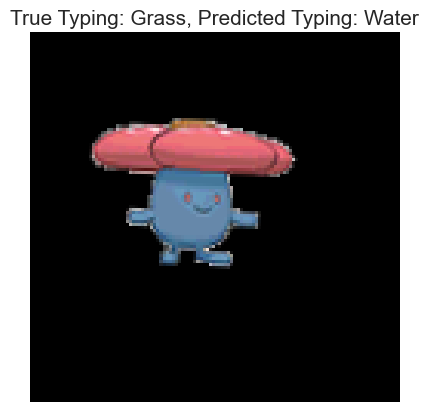

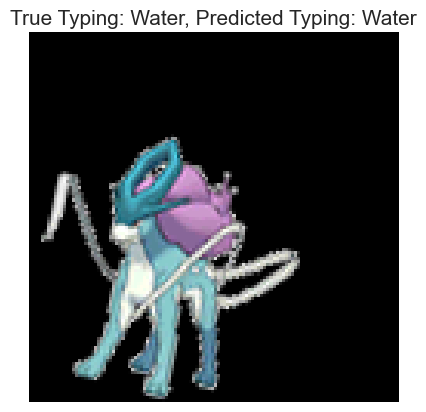

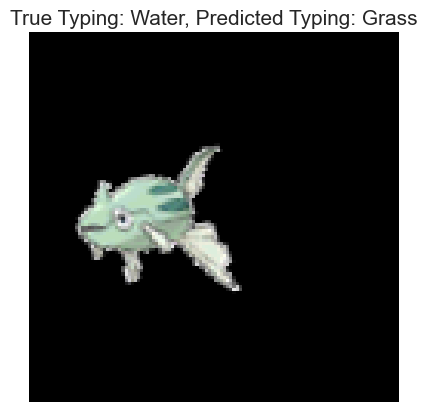

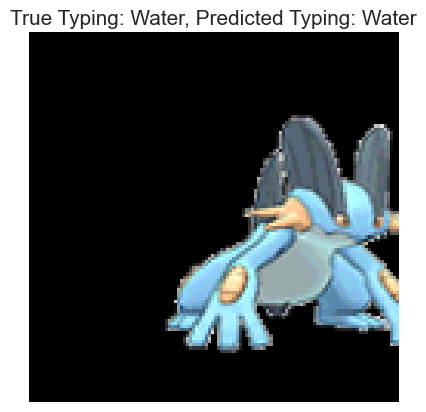

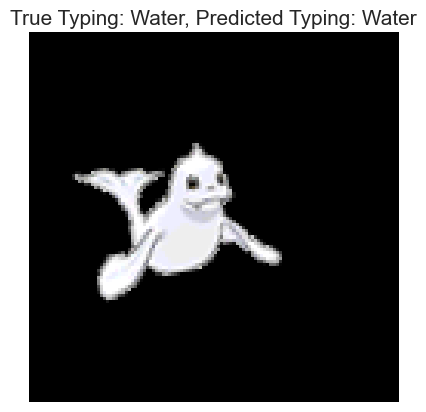

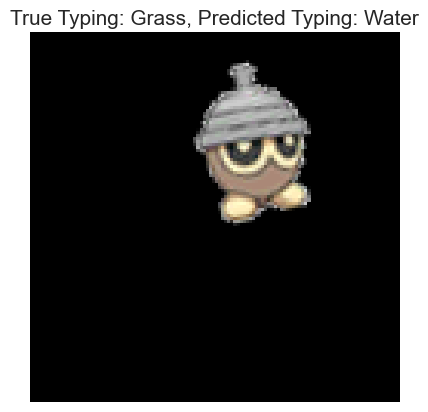

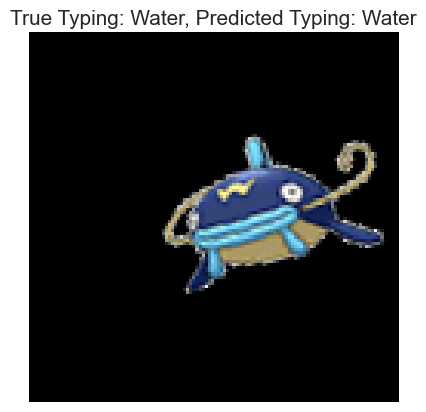

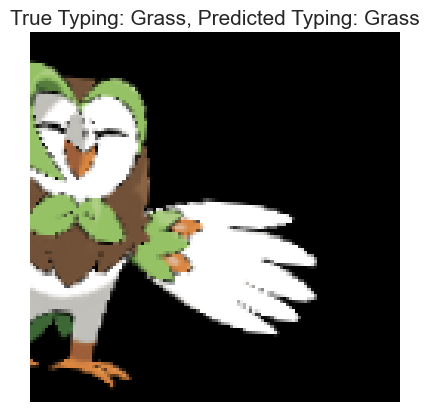

In [52]:
# Resize validation data to match the expected shape of the model
x_val_sample, y_val_sample = next(val_data)
x_val_sample_resized = tf.image.resize(x_val_sample, (224, 224))

class_names = ["grass", "water"]

# Make predictions on resized validation data
predictions = model.predict(x_val_sample_resized)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Print true labels and predicted labels
print("True labels: ", y_val_sample)
print("Predicted labels: ", predicted_classes)

# Display a few images and their true/predicted labels
num_images_to_display = 10

class_names = ["Grass","Water"]
y_val_sample = y_val_sample.astype(int)

for i in range(num_images_to_display):
    plt.imshow(x_val_sample[i])
    true_label = class_names[y_val_sample[i]]
    predicted_label = class_names[predicted_classes[i]]
    plt.title(f"True Typing: {true_label}, Predicted Typing: {predicted_label}")
    plt.axis('off')
    plt.show()

